# Pylops - Least squares image-domain migration

### Author: M.Ravasi

In this notebook we show how to use the ``Kirchhoff`` module to perform image-domain least-squares migration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse.linalg import lsqr

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 2D layered in homogenous velocity

Lets' create a model and geometry

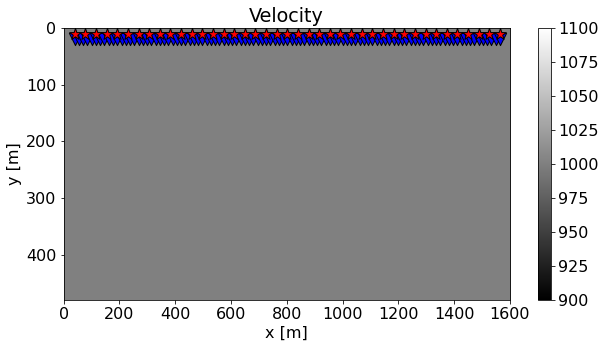

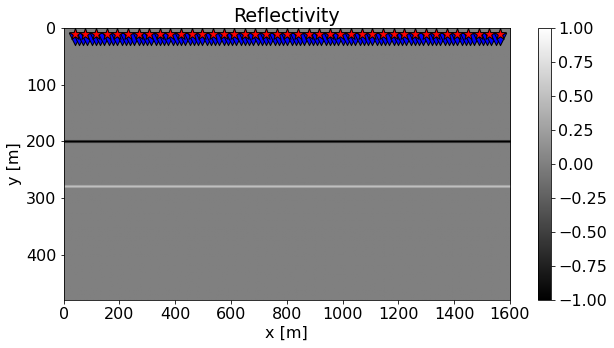

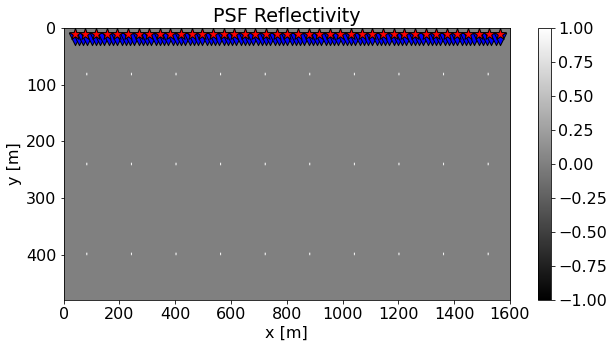

In [2]:
# Velocity Model
nx, nz = 401, 121
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
refl[:, 50] = -1
refl[:, 70] = 0.5

# PSF Model
psfrefl = np.zeros((nx, nz))
psfin = (20, 20)
psfend = (-20, -20)
psfj = (40, 40)
psfrefl[psfin[0]:psfend[0]:psfj[0], psfin[1]:psfend[-1]:psfj[-1]] = 1

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 41
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(10,5))
im = plt.imshow(psfrefl.T, cmap='gray', vmin=-1, vmax=1, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('PSF Reflectivity')
plt.xlim(x[0], x[-1]);

### Dataset creation and migration

In [3]:
nt = 351
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

kop = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', 
                dynamic=False, wavfilter=True, engine='numba')
kopdyn = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', 
                   dynamic=True, wavfilter=True, aperture=2, angleaperture=50, engine='numba')

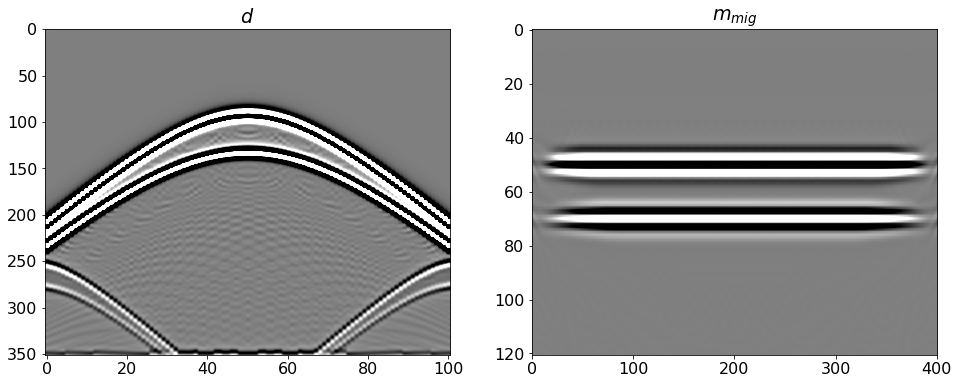

In [4]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)

mmig = kopdyn.H * d.ravel()
mmig = mmig.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(d[ns//2, :, :].T, cmap='gray', vmin=-100, vmax=100)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(mmig.T, cmap='gray', vmin=-100, vmax=100)
axs[1].set_title(r'$m_{mig}$')
axs[1].axis('tight');

### PSF creation and migration

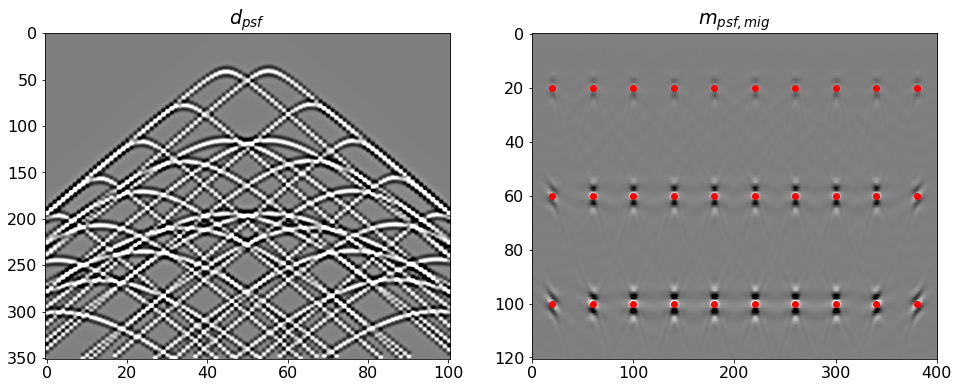

In [5]:
dpsf = kop * psfrefl.ravel()
dpsf = dpsf.reshape(ns, nr, nt)

mmigpsf = kopdyn.H * dpsf.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

#psfs
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])
Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(dpsf[ns//2, :, :].T, cmap='gray', vmin=-100, vmax=100)
axs[0].set_title(r'$d_{psf}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-50, vmax=50)
axs[1].scatter(Psfx.ravel(), Psfz.ravel(), c='r')
axs[1].set_title(r'$m_{psf,mig}$')
axs[1].axis('tight');

### Image domain LSM

First, we extract the different PSFs

In [6]:
psfsize = (21, 21)
psfs = np.zeros((len(psfx), len(psfz), *psfsize))

for ipx, px in enumerate(psfx):
    for ipz, pz in enumerate(psfz):
        psfs[ipx, ipz] = mmigpsf[int(px-psfsize[0]//2):int(px+psfsize[0]//2+1), 
                                 int(pz-psfsize[1]//2):int(pz+psfsize[1]//2+1)] 

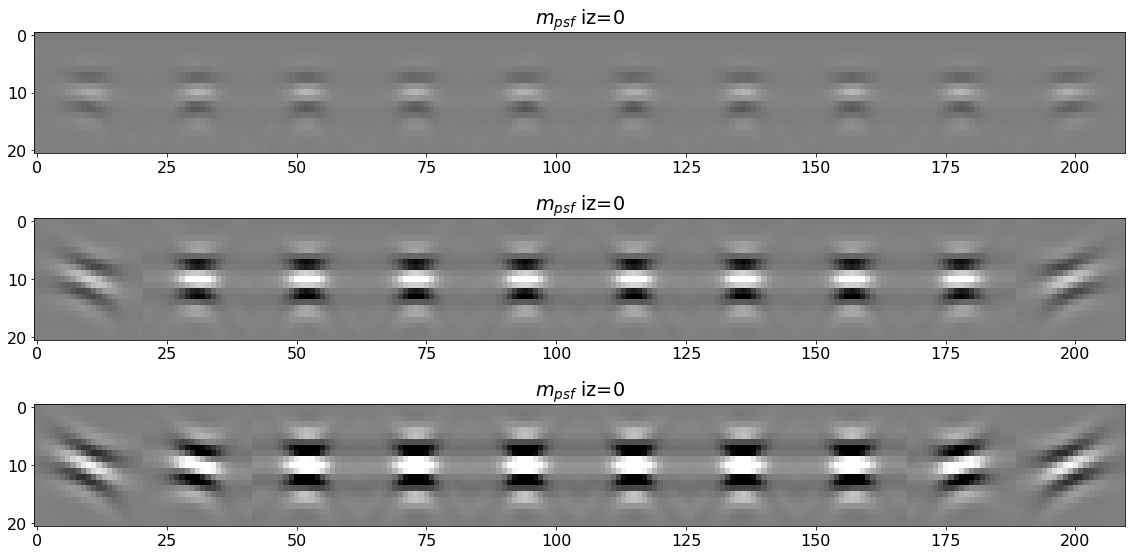

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].imshow(psfs[:, 0].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-50, vmax=50)
axs[0].set_title(r'$m_{psf}$ iz=0')
axs[0].axis('tight')
axs[1].imshow(psfs[:, 1].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-50, vmax=50)
axs[1].set_title(r'$m_{psf}$ iz=0')
axs[1].axis('tight')
axs[2].imshow(psfs[:, 2].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-50, vmax=50)
axs[2].set_title(r'$m_{psf}$ iz=0')
axs[2].axis('tight')
plt.tight_layout()

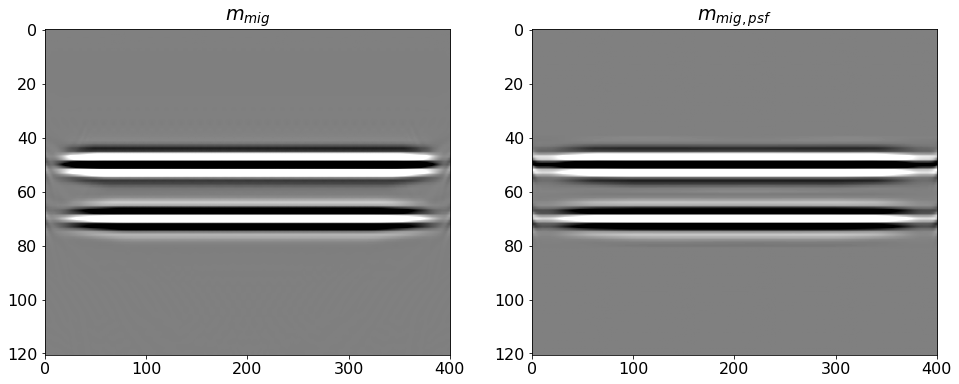

In [8]:
Cop = NonStationaryConvolve2D(hs=psfs, ihx=psfx, ihz=psfz, dims=(nx, nz), engine="numba")

mmigpsf = Cop * refl.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-100, vmax=100)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-100, vmax=100)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight');

In [9]:
dottest(Cop, verb=True, raiseerror=False);

Dot test passed, v^H(Opu)=-131712.1218623351 - u^H(Op^Hv)=-131712.12186233516


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 48521 rows and 48521 cols
eps = 1.000000e+04	tol = 1.000000e-10	niter = 100
alpha = 8.203634e-08	thresh = 4.101817e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         8.698e+07   8.887e+07   2.079e+00
     2       0.0000e+00         6.154e+07   6.475e+07   1.518e+00
     3       0.0000e+00         4.217e+07   4.665e+07   1.504e+00
     4       0.0000e+00         2.863e+07   3.426e+07   1.404e+00
     5       0.0000e+00         1.968e+07   2.631e+07   1.263e+00
     6       0.0000e+00         1.397e+07   2.139e+07   1.108e+00
     7       0.0000e+00         1.037e+07   1.840e+07   9.574e-01
     8       0.0000e+00         8.050e+06   1.657e+07   8.255e-01
     9       0.0000e+00         6.467e+06   1.536e+07   7.192e-01
    10       0

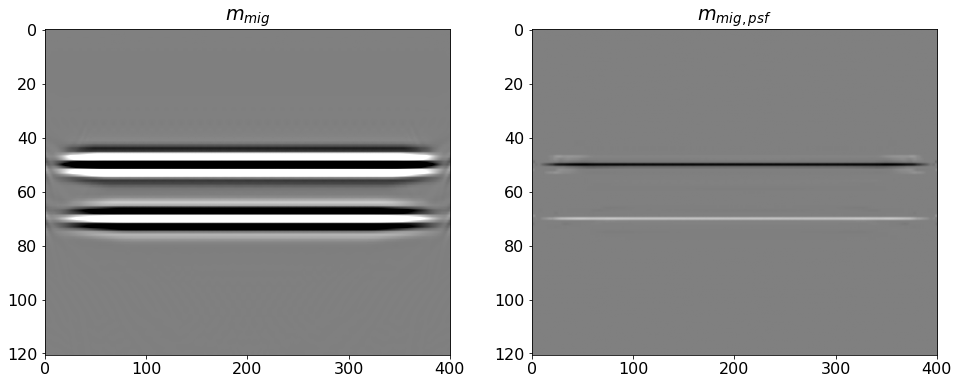

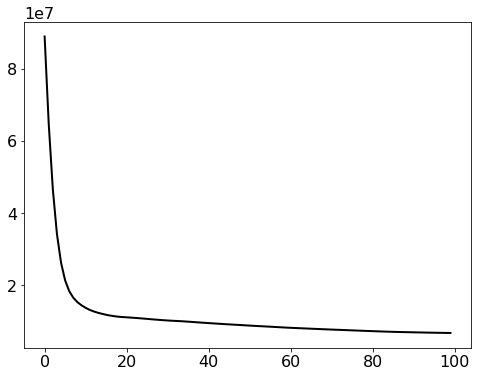

In [10]:
reflinv, _, resnorm = fista(Cop, mmig.ravel(), eps=1e4, niter=100, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = reflinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-100, vmax=100)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')

plt.figure()
plt.plot(resnorm, 'k', lw=2);

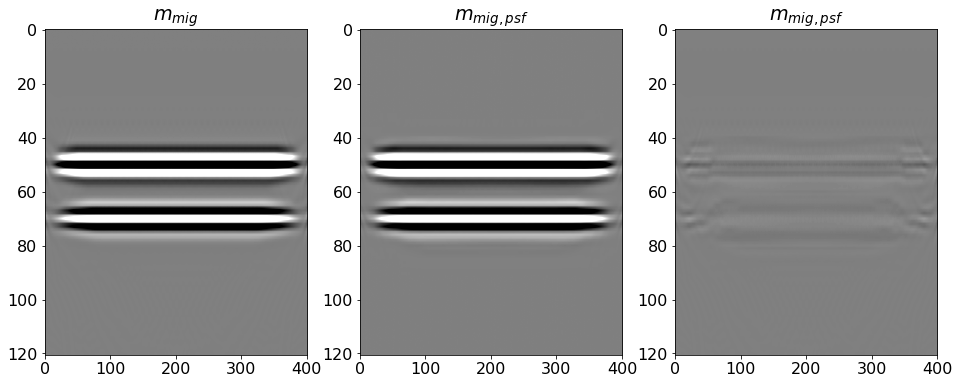

In [11]:
dinv = Cop @ reflinv.ravel()
dinv = dinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-100, vmax=100)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(dinv.T, cmap='gray', vmin=-100, vmax=100)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-dinv.T, cmap='gray', vmin=-100, vmax=100)
axs[2].set_title(r'$m_{mig, psf}$')
axs[2].axis('tight');

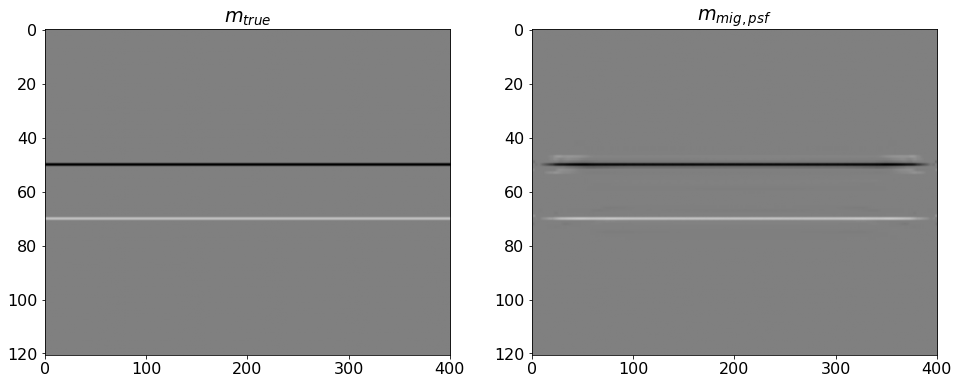

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(refl.T, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title(r'$m_{true}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight');